In [33]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, classification_report, confusion_matrix, accuracy_score, log_loss, roc_curve, roc_auc_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.model_selection import train_test_split, KFold

## **Regression Metrics**

The regression metrics we learned about in class are:
* MSE
* RMSE
* MAE
* MAPE
* r squared
* adjusted r squared

In this section of the notebook, I generate some fake data and fit a linear regression model to that data. Then I show how to calculate all those metrics for the model on the training data.

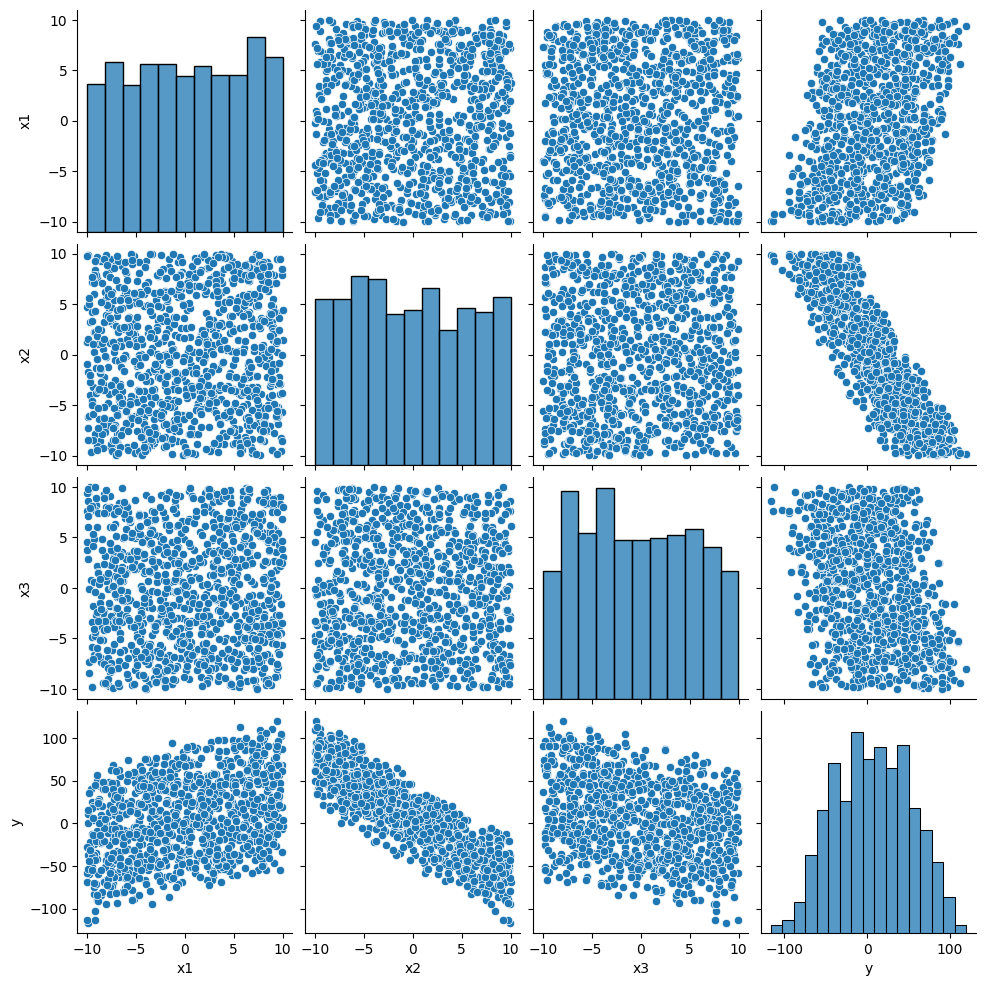

In [2]:
#generate synthetic training data
np.random.seed(12)
x1 = np.random.uniform(-10, 10, size = 1000)
x2 = np.random.uniform(-10,10, size = 1000)
x3 = np.random.uniform(-10,10, 1000)

y = 3 * x1 - 7 * x2 - 2.5 * x3 + 4 + np.random.normal(scale = 1, size = 1000)

training_df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y': y})

sns.pairplot(training_df)


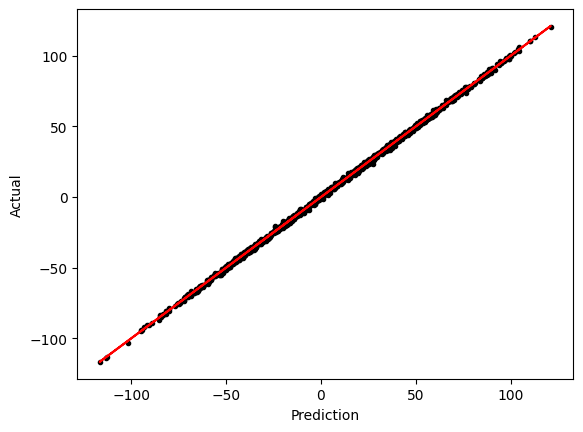

In [3]:
#fit the linear regression model

lm = LinearRegression().fit(training_df[['x1', 'x2', 'x3']].values, training_df.y.values)
preds = lm.predict(training_df[['x1', 'x2', 'x3']].values)

#plot the predictions
plt.plot(preds, training_df.y.values, 'k.')
plt.plot(preds, preds, 'r-')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [4]:
#mean squared error
mean_squared_error(y, preds)

0.9721020055450621

In [5]:
#root mean squared error
root_mean_squared_error(y, preds)

0.9859523343169598

In [6]:
#mean absolute error
mean_absolute_error(y, preds)

0.7806835784156423

In [7]:
#mean absolute percentage error
mean_absolute_percentage_error(y, preds)

0.09906398623906038

In [8]:
# r squared
r2_score(y, preds)

0.9995466998165227

## **Classification Metrics**

The classifier metrics we learned about in class are

* confusion matrices (true positives, true negatives, false positives, false negatives)
* accuracy
* precision
* recall (sensitivity, true positive rate)
* false positive rate (fallout)
* specificity (true negative rate)
* F1 score
* ROC and ROC AUC
* Precision-Recall curve
* log loss (cross entropy loss)
* calibration plots

Using the same synthetic data from the regression section, I treat the outputs as logits, convert them to probabilities, then sample binary outcomes. Then I learn a logistic regression model. Finally, I show how to calculate all of the above metrics on the logistic regression model.

In [9]:
#the expit function is just the sigmoid function, so we can use it to convert logits to probabilities
from scipy.special import expit
logits = y.copy()

probs = expit(logits)

#generate the binary y data
np.random.seed(33)
y = np.random.binomial(n = 1, p = probs)
training_df['y'] = y

In [11]:
#fit the logistic regression model
lm = LogisticRegression().fit(training_df[['x1', 'x2', 'x3']].values, training_df.y.values)

preds = lm.predict(training_df[['x1', 'x2', 'x3']].values)

#note with sklearn classifiers you can also predict the probability. The predict_proba
#function returns a numpy array with two columns. The first column is the probability of the 0 class,
#and the second column is the probability of the 1 class, so we want the second column
pred_probs = lm.predict_proba(training_df[['x1', 'x2', 'x3']].values)[:,1]

In [12]:
#first up: we can calculate precision, recall, and f1 all at the same time using sklearn's classification_report function
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       455
           1       0.99      0.99      0.99       545

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [14]:
#next up, a confusion matrix
conf_mat = confusion_matrix(y, preds)
conf_mat

array([[448,   7],
       [  5, 540]])

The confusion matrix has the following format, so based on this you can figure out how many true positives, true negatives, false positives, and false negatives that your model has by looking at the output from the previous cell.

| Actual \ Predicted | Positive (P) | Negative (N) |
|---------------------|--------------|--------------|
| Positive (P)        | True Positive (TP) | False Negative (FN) |
| Negative (N)        | False Positive (FP) | True Negative (TN) |

In [17]:
#false positive rate is false positives / false positives + true negatives
fpr = (conf_mat[1,0] / np.sum(conf_mat[1,:])).item()
fpr

0.009174311926605505

In [18]:
#specificity (true negative rate) is true negatives / true negatives + false positives
tnr = (conf_mat[1,1] / np.sum(conf_mat[1,:])).item()
tnr

0.9908256880733946

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


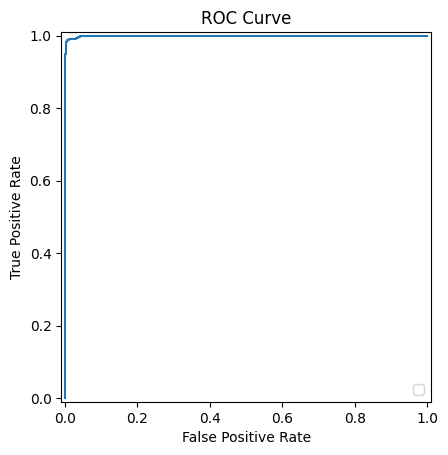

0.9994596229458614

In [20]:
#roc curve
fpr, tpr, thresholds = roc_curve(y, pred_probs)
display = RocCurveDisplay(fpr = fpr, tpr = tpr)
display.plot()
plt.title('ROC Curve')
plt.show()

#area under roc curve
roc_auc_score(y, pred_probs).item()

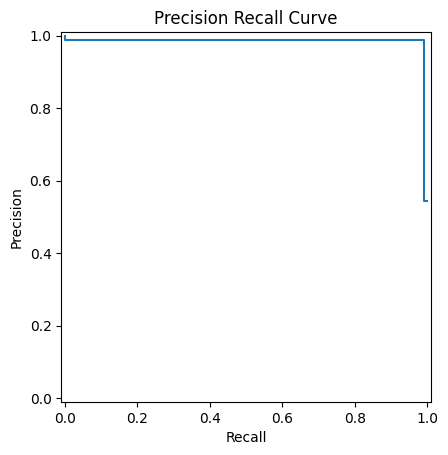

In [21]:
#precision recall curve
precision, recall, _ = precision_recall_curve(y, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision Recall Curve')
plt.show()

In [22]:
#log loss/cross entropy loss
log_loss(y, pred_probs)

0.03343520046232376

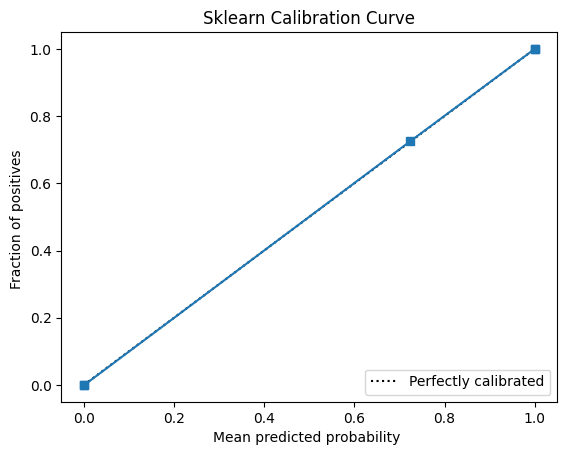

In [27]:
#calibration plots: sklearn's version
prob_true, prob_pred = calibration_curve(y, pred_probs, strategy = 'quantile', n_bins =  5)
disp = CalibrationDisplay(prob_true, prob_pred, pred_probs)
disp.plot()
plt.title('Sklearn Calibration Curve')
plt.show()

Try playing around with different numbers of bins to see how it changes! The default is 5.

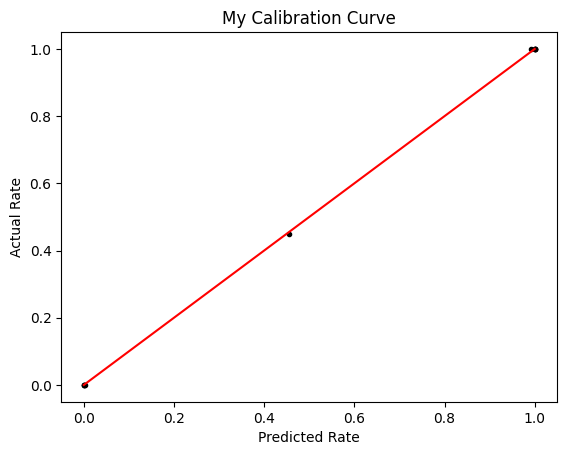

In [32]:
#calibration curve: my version. I think my version is prettier

def calibration(preds, actuals, groupsize = 100, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

calibration(pred_probs, y, groupsize = 100, title = 'My Calibration Curve')

## **Train test split and cross validation**

Using the binary data I just generated to train the logistic regression model, I will now show how to do a train test split, k fold cross validation, and bootstrapped cross validation

In [34]:
#train test split. I went with a 70/30 train test split
train, test = train_test_split(training_df, train_size = 0.7)

#train a model
mod = LogisticRegression().fit(train[['x1', 'x2', 'x3']].values, train.y.values)

#calcluate the log loss on both the train and test set to assess overfitting. Note I chose log loss because it's one of my go tos, but you could use any metric you wanted
train_ll = log_loss(train.y.values, mod.predict_proba(train[['x1', 'x2', 'x3']].values)[:,1])
test_ll = log_loss(test.y.values, mod.predict_proba(test[['x1', 'x2', 'x3']].values)[:,1])
train_ll, test_ll

(0.03563483539622148, 0.033732919928129046)

since the train and test set log losses are similar, we would conclude that we probably aren't overfitting.

In [40]:
#k fold cross validation. Note I chose K = 5
train_set_log_losses = []
test_set_log_losses = []
for tr, te in KFold(n_splits = 5).split(training_df):
  train = training_df.iloc[tr]
  test = training_df.iloc[te]
  #fit a model
  mod = LogisticRegression().fit(train[['x1', 'x2', 'x3']].values, train.y.values)

  #calcluate the log loss on both the train and test set to assess overfitting. Note I chose log loss because it's one of my go tos, but you could use any metric you wanted
  train_ll = log_loss(train.y.values, mod.predict_proba(train[['x1', 'x2', 'x3']].values)[:,1])
  test_ll = log_loss(test.y.values, mod.predict_proba(test[['x1', 'x2', 'x3']].values)[:,1])
  train_set_log_losses.append(train_ll)
  test_set_log_losses.append(test_ll)

In [41]:
#now we have five train and test set log losses, one for each split in our Kfold cross validation
train_set_log_losses, test_set_log_losses

([0.029522831295394524,
  0.03572391109416914,
  0.03628062510889441,
  0.03594045309464934,
  0.03047222580694336],
 [0.05826037909253975,
  0.030916326151866312,
  0.02833034742793246,
  0.02947850722226181,
  0.05095633836951483])

In [42]:
np.mean(train_set_log_losses), np.mean(test_set_log_losses)

(np.float64(0.033588009280010156), np.float64(0.03958837965282303))

Since the mean train set and test set log losses are similar in the K fold cross validation, we would conclude that we aren't overfitting

In [43]:
#bootstrap cross validation: the Heaton approach

#for some large number of iterations, do a train test split and calculate whatever metric you are interested in. I am sticking with log loss for this example
train_set_log_losses = []
test_set_log_losses = []

for iter in range(1000):
  #get a train test split. I chose a 70/30 train test split size, but you could choose something else
  train, test = train_test_split(training_df, train_size = 0.7)

  #fit a model
  mod = LogisticRegression().fit(train[['x1', 'x2', 'x3']].values, train.y.values)

  #calcluate the log loss on both the train and test set to assess overfitting
  train_ll = log_loss(train.y.values, mod.predict_proba(train[['x1', 'x2', 'x3']].values)[:,1])
  test_ll = log_loss(test.y.values, mod.predict_proba(test[['x1', 'x2', 'x3']].values)[:,1])
  train_set_log_losses.append(train_ll)
  test_set_log_losses.append(test_ll)

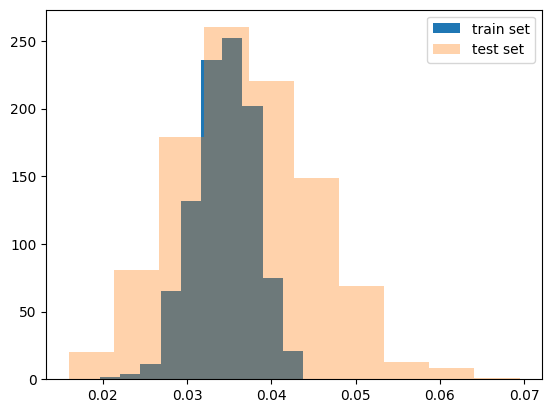

In [46]:
#now we can visualize the distribution of train and test set log losses!
plt.hist(train_set_log_losses, label = 'train set')
plt.hist(test_set_log_losses, label = 'test set', alpha = 0.35)
plt.legend()
plt.show()
